In [1]:
import os
import pandas as pd
import re
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer



# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/asa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/asa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/asa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/asa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/asa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/asa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)


lemmatizer = WordNetLemmatizer()


# Additional preprocessing
stop_words = set(stopwords.words('english'))
custom_stopwords = ['older', 'people', 'adults','like','make','help','kentucky','members','use','users','user','world','aging','using','seniors','senior','age','product','products','new','year','years','000','provide','provides','based','team','way', 'we','are','we_are','nan','nan_nan','tc', 'pineway','medly','enables','ehr','northwest', 'without', 'balloon','face','Other','stakeholder', 'dml','which_allows','qura','._','africa','will_allow','cisco','\'ll','ranging_from','avizia','whose_mission','--','ehrs','zorpia','hellocare','//care.coach','karie','byenbye','cost_to','binata','inc.','etc','2_)','1_)','\'_s','80%_%','20%_%','those_who','llc','we_offer','inclue','others','list','top','yet','NOVELTY','e.g','1-3','12a','cam','mpu6050','cic'
                    ]  
stop_words.update(custom_stopwords)
punctuation = set(string.punctuation)

def preprocess(tokens):
    filtered_tokens = []
    for token in tokens:
        lower_token = token.lower()
        if (lower_token not in stop_words and 
            lower_token not in punctuation and 
            not lower_token.isdigit() and 
            len(lower_token) > 1):
            lemmatized_token = lemmatizer.lemmatize(lower_token, get_wordnet_pos(lower_token))
            filtered_tokens.append(lemmatized_token)
    return filtered_tokens

In [3]:
df1 = pd.read_csv('/Users/asa/VScode/patent/all_patents.csv')
df2 = pd.read_csv('/Users/asa/VScode/patent/patent_company.csv')

df1['text'] = df1[[' TI ',' AB ']].astype(str).agg(' '.join, axis=1)
df2['text'] = df2[['Title','abstract','content1','content2']].astype(str).agg(' '.join, axis=1)

df1['assignee'] = df1[' AE ']  
df2['assignee'] = df2['Assignee']  
df1['patent number'] = df1['PN ']
df2['patent number'] = df2['PN']

temp_df1 = df1[['text', 'assignee','patent number']]
temp_df2 = df2[['text', 'assignee','patent number']]
combined_df = pd.concat([temp_df1, temp_df2], ignore_index=True)

combined_df.dropna(subset=['text'], inplace=True)

# Detecting Phrases (Bigrams)
# First, tokenize the text for phrase modeling
sentence_stream = [word_tokenize(doc.lower()) for doc in combined_df['text']]
bigram_model = Phrases(sentence_stream, min_count=10, threshold=50)  # Tune these parameters as needed
bigram_phraser = Phraser(bigram_model)

# Apply the bigram model to each document
combined_df['bigram_tokens'] = combined_df['text'].apply(lambda doc: bigram_phraser[word_tokenize(doc.lower())])

combined_df['tokens'] = combined_df['bigram_tokens'].apply(preprocess)

sample_text = combined_df['text'].iloc[0]
print("Before preprocessing:", sample_text)
print("After preprocessing:", preprocess(sample_text))


Before preprocessing: Method for implementing selected restriction of telephone call service on wireless communications device based on location of wireless communications device, involves controlling service for wireless communication device    NOVELTY - The method involves determining whether a wireless communication device is located within a zone of coverage comprising a moving, dynamically defined region. Permissibility of a service for the wireless communication device is determined, where types of the permissibility comprise a first permissibility and a second permissibility. The service for the wireless communication device is controlled while the wireless communication device is within the zone of coverage based on the permissibility, where the second permissibility restricts the service for the wireless communication device. USE - Method for implementing selected restriction of a wireless communications service i.e. telephone call service (claimed) on a wireless communication

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokenized documents back to strings
combined_df['processed_text'] = combined_df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=4, stop_words='english')

# Fit and transform the processed texts to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_df['processed_text'])

# tfidf_matrix is a sparse matrix of shape (n_samples, n_features)


# preprocess endding
# word2vec training and vectorization

In [5]:
from gensim.models import Word2Vec

# Correct approach using already tokenized text
texts = combined_df['tokens'].tolist()  # This should be a list of lists now
model = Word2Vec(sentences=texts, vector_size=500, window=20, min_count=4, sg=1)
# Inspect the model's vocabulary
vocabulary_words = list(model.wv.key_to_index.keys())
print("Corrected vocabulary sample:", vocabulary_words[:10])
import numpy as np

def document_vector(word_model, doc):
    # Remove out-of-vocabulary words and compute the average vector
    doc = [word for word in doc if word in word_model.wv]
    if len(doc) == 0:
        return np.zeros(word_model.vector_size)
    return np.mean(word_model.wv[doc], axis=0)

# Apply the function to vectorize all documents
doc_vectors = np.array([document_vector(model, doc) for doc in texts])

Corrected vocabulary sample: ['device', 'system', 'module', 'mobile', 'information', 'draw', 'method', 'data', 'terminal', 'connect']


In [6]:
print(doc_vectors.shape)
print(tfidf_matrix.shape)

(5949, 500)
(5949, 5567)


In [7]:
import numpy as np

# Concatenate the arrays along axis 1
combined_features = np.concatenate((doc_vectors, tfidf_matrix.toarray()), axis=1)


# Drawing figure

/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

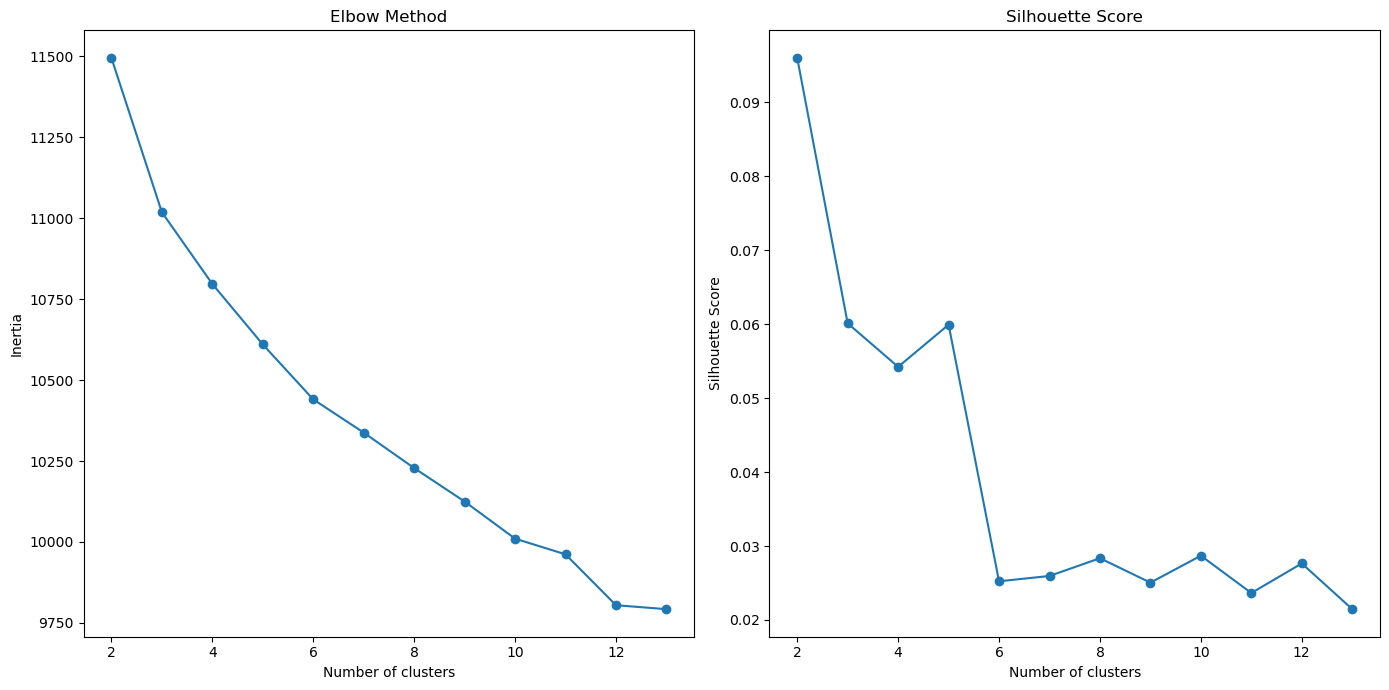

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette_scores = []

# Define the range of clusters to try
range_of_clusters = range(2, 14)  # For example, from 2 to 10

for n_clusters in range_of_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(combined_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(combined_features, kmeans.labels_))

# Plotting the Elbow Method graph
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range_of_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [9]:
# Choose the number of clusters
num_clusters = 5  # Adjust based on your needs

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(combined_features)
# Assign the cluster labels to your original DataFrame
combined_df['cluster'] = kmeans.labels_


/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


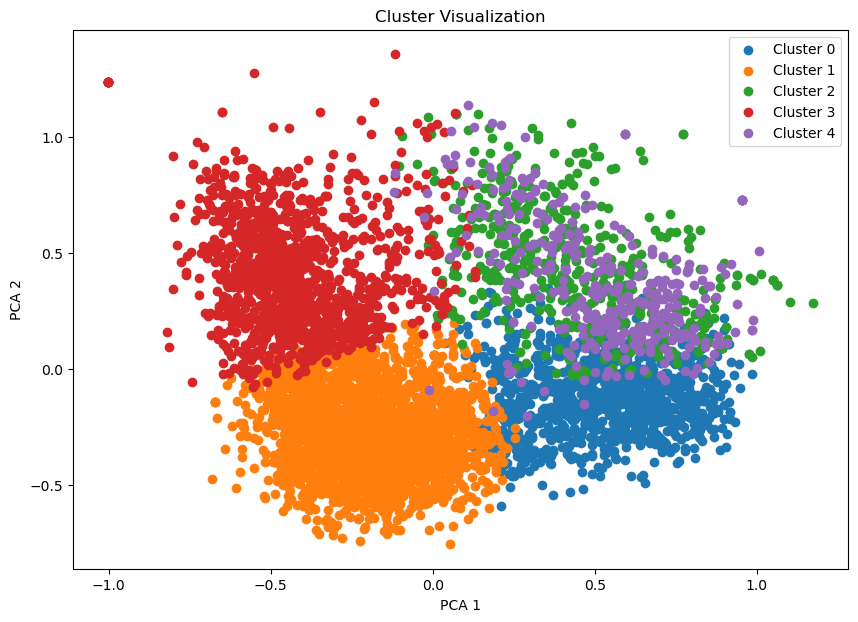

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(combined_features)

# Plot the clusters
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    plt.scatter(reduced_vectors[kmeans.labels_ == i, 0], reduced_vectors[kmeans.labels_ == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Cluster Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [11]:
from scipy.spatial.distance import cdist  # Add this import statement

centroids = kmeans.cluster_centers_

def find_closest_words(features, centroid, word_model, top_n=40):
    # Compute the cosine similarity between the centroid and all word vectors
    distances = cdist(features, [centroid], "cosine")[..., 0]
    # Get the indices of the top_n smallest distances
    closest_word_indices = distances.argsort()[:top_n]
    # Return the corresponding words
    return [word_model.index_to_key[i] for i in closest_word_indices]

# For each cluster centroid, find and print the closest words
for i, centroid in enumerate(centroids):
    words = find_closest_words(combined_features, centroid, model.wv)
    print(f"Cluster {i}: {', '.join(words)}")


Cluster 0: perturbation, confusion, oscillator, interchangeable, informational, graphic, merchandise, dimensional, jms, mainframe, mould, expo, manifestation, phosphorescent, objective, investment, s104, healthy_cell, fixed-point, therapist, m900, wap, nest, unusual, factory, e-mail, headrest, musculoskeletal, root, ammeter, rewalk, verifies, 62/354,833, guaranteed, end-user, sore, alertness, pp2a, fence, six
Cluster 1: guidance, gps, bed, later, apply, headphone, rehabilitation_training, acquires, behaviour, doorbell, compartment, short_message, isolated, portal, transient_care, increase, badge, prevention, electronically, garment, battery, number, optimization, cloud, ear_canal, communicate, gas_stove, financial, market, space, fault, high-frequency, function, blade, agent, tail, takes_thermal, tv, critical, instrument
Cluster 2: conductive_peninsula, decorative, supplementary, tumor, implantation, oxygen_saturation, guardrail, 360_degrees, inventory_item, organic, heater, pivot, dre

In [12]:
import pandas as pd

# Assume 'combined_df' is your DataFrame containing the documents
# Assign cluster labels to each document based on the cluster assignments
combined_df['cluster_label'] = kmeans.labels_

# Save the DataFrame to a CSV file
combined_df.to_csv('label.csv', index=False)

print("Cluster labels added and saved to CSV file.")


Cluster labels added and saved to CSV file.
